In [1]:

import matplotlib.pyplot as plt 
import numpy as np
from scipy.io import wavfile
from numpy.fft import fft, ifft
import scipy.signal as sig


external dependencies:
* ./AmAud1.py 
* ./audiolibrary.json
* sqlite table: samplelibrary

In [2]:
%load_ext sql
%sql sqlite:///capstone_orchestra.db

In [3]:
# https://pypi.org/project/ipython-sql/

# definition of the Signal Processor object
### the class definition is stored in a separate file so that it will be shared among multiple notebooks

In [4]:
from AmAud1 import AmAud1

# definition of the samples

11 samples taken from two separate online archives - one for training purposes and one for testing
* https://theremin.music.uiowa.edu/MIS-Pitches-2012/ - for training (6 samples)
* https://freesound.org - for testing (5 samples)
* https://samplefocus.com

In [5]:
import json
with open('audiolibrary.json') as audiolibrary_file:
    library = json.load(audiolibrary_file)
    
print('library loaded with',len(library),'items')

library loaded with 18 items


In [6]:
import pandas as pd
df = pd.DataFrame.from_dict(library, orient='columns')
df.head()

,label,istm,train,wav,source_url,source_owner,note,desc,take_s
0,Bassoon1a,Bassoon,1,M:/DATALAKE/AUDIO/theremin_music_uiowa_edu/aif...,https://theremin.music.uiowa.edu/MIS-Pitches-2...,,A3,A3=220(224Hz) but max peak is at 447Hz,"[0.2, 1]"
1,Bassoon2a,Bassoon,1,M:/DATALAKE/AUDIO/freesound/21001__samulis__vs...,https://freesound.org/people/Samulis/packs/21001/,https://freesound.org/people/Samulis/,A4,,"[1, 1]"
2,Bassoon3a_x,Bassoon,0,M:/DATALAKE/AUDIO/freesound/9544__carlos_vaque...,https://freesound.org/people/Carlos_Vaquero/so...,https://freesound.org/people/Carlos_Vaquero/,G3,G3=196 --- see https://muted.io/note-frequencies/,"[2, 1]"
3,Viola1a,Viola,1,M:/DATALAKE/AUDIO/theremin_music_uiowa_edu/aif...,https://theremin.music.uiowa.edu/MIS-Pitches-2...,Anton Krutz (2001),A3,A3=220(226Hz) also max peak,"[0.5, 1]"
4,Viola2a,Viola,1,M:/DATALAKE/AUDIO/freesound/509155__michelemik...,https://freesound.org/people/michelemiko/sound...,https://freesound.org/people/michelemiko/,G3,,"[7.7, 1]"


In [7]:
audiolibrary = df

In [8]:
audiolibrary = audiolibrary.rename(columns={'desc':'descr'})

In [9]:
audiolibrary['take_s_from'] = audiolibrary.apply(lambda row: row['take_s'][0], axis=1)
audiolibrary['take_s_long'] =   audiolibrary.apply(lambda row: row['take_s'][1], axis=1)

In [10]:
tempo = AmAud1('temp',{})

In [11]:
audiolibrary['note_hz'] =  audiolibrary.apply(lambda row: round(tempo.util_parsenote(row['note']),3) , axis=1) 

In [12]:
audiolibrary = audiolibrary.drop(['take_s'], axis=1)

In [13]:
%sql drop table audiolibrary

 * sqlite:///capstone_orchestra.db
Done.


[]

In [14]:
# %sql drop table samplelibrary ... is not fatal if table does not exist

In [15]:
# %sql --persist --append library

In [16]:
%sql --persist audiolibrary

 * sqlite:///capstone_orchestra.db


'Persisted audiolibrary'

In [17]:
#df.to_sql("library", con, if_exists='replace',index=True)

In [18]:
%sql SELECT label,istm,train,note,note_hz,take_s_from,take_s_long FROM audiolibrary where take_s_long <> 1;

 * sqlite:///capstone_orchestra.db
Done.


label,istm,train,note,note_hz,take_s_from,take_s_long
Viola3a_x,Viola,0,G4,391.995,1.2,0.1
Cello1a,Cello,1,A2,110.0,6.3,2.0
FrHorn2a,FrHorn,1,A2,110.0,1.0,2.0
Clarinet2a,Clarinet,1,F5,698.456,5.1,0.2


In [19]:
zz = np.array([10.,12.,15.,20.,25.])

In [20]:
np.argmax(zz>14.)

2

* useful website with interactive piano keyboard with frequencies and notes/octaves:
* https://muted.io/note-frequencies/

In [21]:
def check_uniqueness_of_library_field(library,field):
    labels = [ dd[field] for dd in library]
    print(len(set(labels)),'distinct values of',field,'found in',len(library),'library items')
    return len(labels) == len(set(labels))

In [22]:
assert check_uniqueness_of_library_field(library,'label')
assert check_uniqueness_of_library_field(library,'wav')

18 distinct values of label found in 18 library items
18 distinct values of wav found in 18 library items


In [23]:
pd.crosstab(index = df.istm, columns = df.train, values=df.train, aggfunc='count')

train,0,1
istm,,
Bassoon,1,2
Cello,1,2
Clarinet,1,2
Flute,1,2
FrHorn,1,2
Viola,1,2


# Initial Data Exploration

## plotting the entire, raw signals of the library

In [24]:
def load_dataexp_samples(library,hyperparams,*,cut):
    #hyperparams
    objects = []
    for ddi in range(len(library)):
        dd=library[ddi]
        aa = AmAud1(dd['label'],dd)
        aa.load_wav_file(dd['wav']) # .minmaxscaled()
        #print(aa)
        if cut: aa = aa.set_pcm_cut_s(dd['take_s'][0],dd['take_s'][1])
        objects.append(aa)
    return objects

In [25]:
objects = load_dataexp_samples(library,{},cut=False)
print('loaded',len(objects),'samples')

name: M:/DATALAKE/AUDIO/theremin_music_uiowa_edu/aiff2wav-via-audacity/Bassoon.ff.A3.stereo.wav
freq 44100 snd class <class 'numpy.ndarray'> ndim 2 shape (89670, 2)
channel 0 min -5216 max 5778
channel 1 min -5222 max 5772
len(pcm0) 89670 -1
['time minmax [ms]', 0.0, 2033.3106575963718]
name: M:/DATALAKE/AUDIO/freesound/21001__samulis__vsco-2-ce-woodwinds-bassoon-sustain/372667__samulis__bassoon-sustain-a4-psbassoon_a3_v1_1.wav
freq 44100 snd class <class 'numpy.ndarray'> ndim 2 shape (428309, 2)
channel 0 min -4055 max 4127
channel 1 min -5687 max 3999
len(pcm0) 428309 -22
['time minmax [ms]', 0.0, 9712.19954648526]
name: M:/DATALAKE/AUDIO/freesound/9544__carlos_vaquero__bassoon-fortissimo-and-pianissimo-samples-g3/154276__carlos_vaquero__bassoon-g-3-tenuto-non-vibrato-fortissimo.wav
freq 44100 snd class <class 'numpy.ndarray'> ndim 2 shape (364450, 2)
channel 0 min -21985 max 24449
channel 1 min -21985 max 24450
len(pcm0) 364450 0
['time minmax [ms]', 0.0, 8264.149659863946]
name: M:

M:\DEV\python\NOTEBOOKS\coursera_datascience_advanced_ibm\AmAud1.py:91: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, snd = wavfile.read(wavfn)
M:\DEV\python\NOTEBOOKS\coursera_datascience_advanced_ibm\AmAud1.py:91: WavFileWarning: Incomplete chunk ID: b'\x00', ignoring it.
  fs, snd = wavfile.read(wavfn)


freq 44100 snd class <class 'numpy.ndarray'> ndim 2 shape (127564, 2)
channel 0 min -3879 max 2500
channel 1 min -3293 max 2368
len(pcm0) 127564 1
['time minmax [ms]', 0.0, 2892.5850340136053]
name: M:/DATALAKE/AUDIO/theremin_music_uiowa_edu/aiff2wav-via-audacity/Horn.ff.A4.stereo.wav
freq 44100 snd class <class 'numpy.ndarray'> ndim 2 shape (100673, 2)
channel 0 min -2772 max 5458
channel 1 min -2771 max 5464
len(pcm0) 100673 0
['time minmax [ms]', 0.0, 2282.8117913832198]
name: M:/DATALAKE/AUDIO/samplefocus/french-horn-a1_A.wav
freq 44100 snd class <class 'numpy.ndarray'> ndim 2 shape (186747, 2)
channel 0 min -28109 max 28449
channel 1 min -28109 max 28449
len(pcm0) 186747 -1
['time minmax [ms]', 0.0, 4234.603174603175]
name: M:/DATALAKE/AUDIO/freesound/682231__henkonen__fhorn-18.wav
freq 44100 snd class <class 'numpy.ndarray'> ndim 1 shape (115703,)
MONO min -10304 max 12533
len(pcm0) 115703 0
['time minmax [ms]', 0.0, 2623.6281179138323]
name: M:/DATALAKE/AUDIO/theremin_music_uiow

Bassoon1a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 2.0
Bassoon1a : plotting PCM from 0 to 89670
Bassoon1a : plotting PCM from 0.0 ms to 2033.3 ms


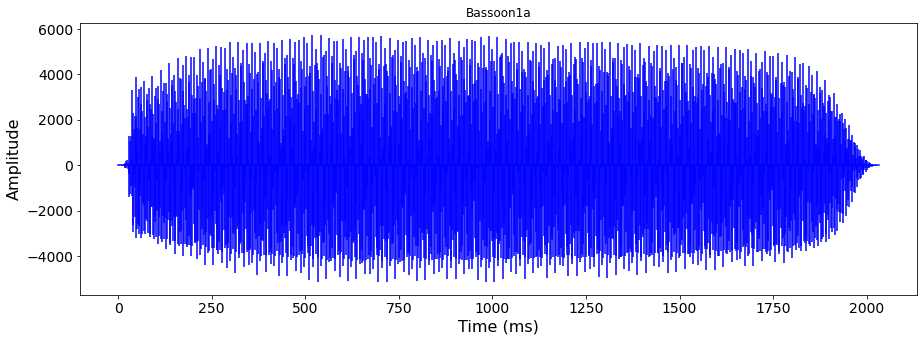

Bassoon2a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 9.7
Bassoon2a : plotting PCM from 0 to 428309
Bassoon2a : plotting PCM from 0.0 ms to 9712.2 ms


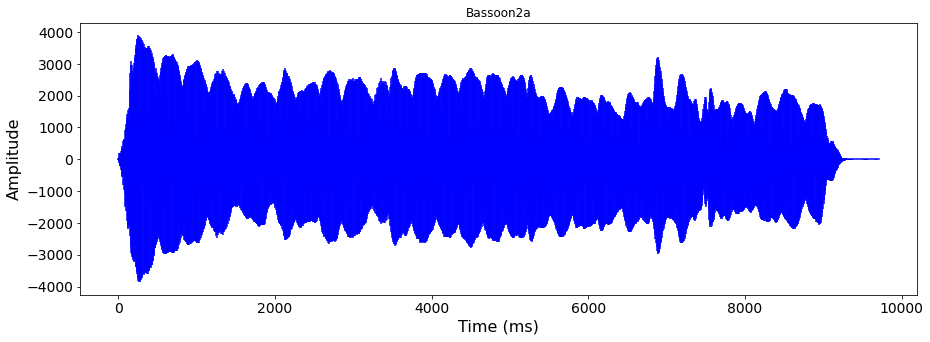

Bassoon3a_x : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 8.3
Bassoon3a_x : plotting PCM from 0 to 364450
Bassoon3a_x : plotting PCM from 0.0 ms to 8264.1 ms


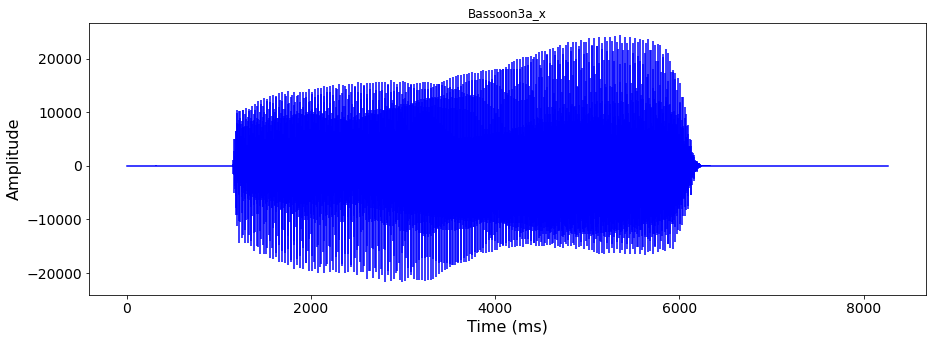

Viola1a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 3.1
Viola1a : plotting PCM from 0 to 138767
Viola1a : plotting PCM from 0.0 ms to 3146.6 ms


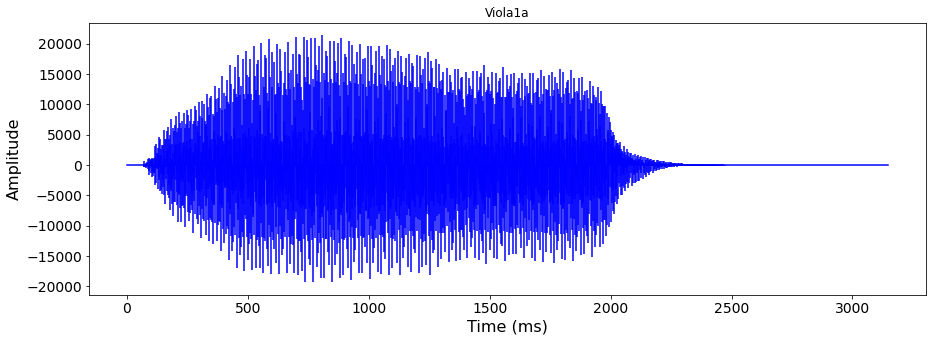

Viola2a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 14.2
Viola2a : plotting PCM from 0 to 624750
Viola2a : plotting PCM from 0.0 ms to 14166.6 ms


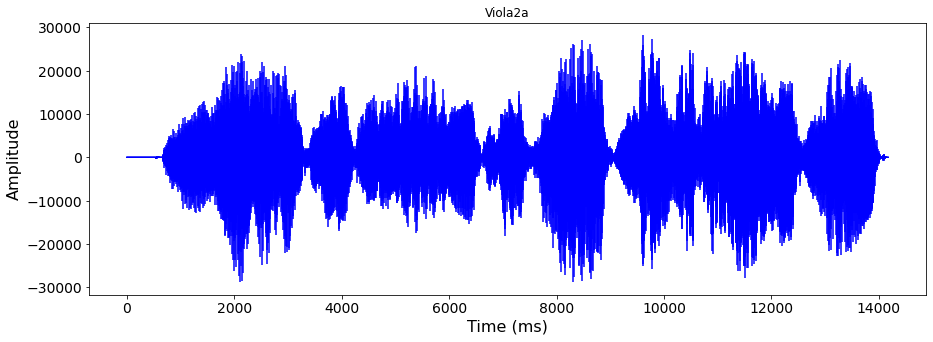

Viola3a_x : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 2.4
Viola3a_x : plotting PCM from 0 to 104097
Viola3a_x : plotting PCM from 0.0 ms to 2360.5 ms


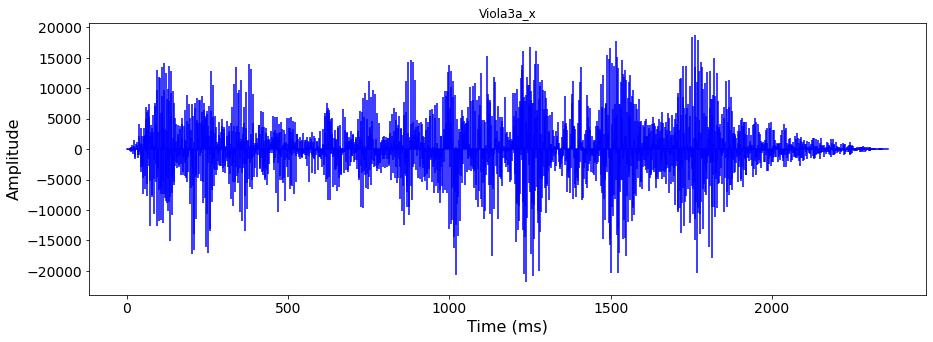

Cello1a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 12.0
Cello1a : plotting PCM from 0 to 576000
Cello1a : plotting PCM from 0.0 ms to 12000.0 ms


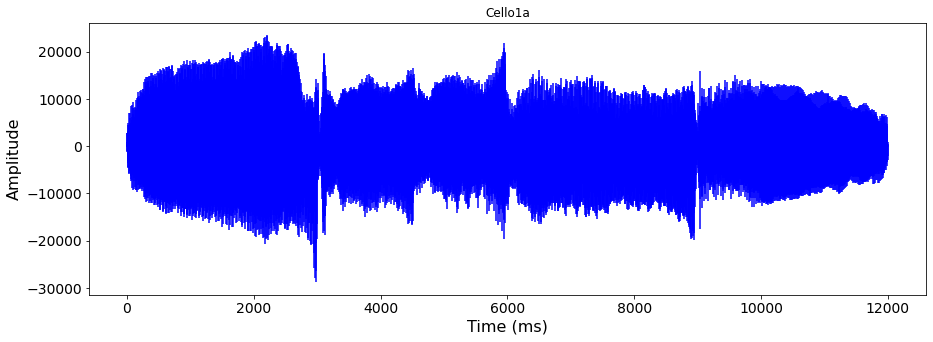

Cello2a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 3.9
Cello2a : plotting PCM from 0 to 171117
Cello2a : plotting PCM from 0.0 ms to 3880.2 ms


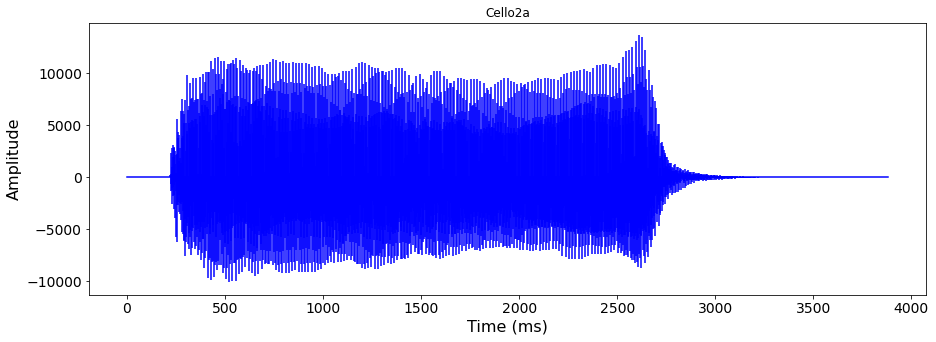

Cello3a_x : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 2.9
Cello3a_x : plotting PCM from 0 to 127564
Cello3a_x : plotting PCM from 0.0 ms to 2892.6 ms


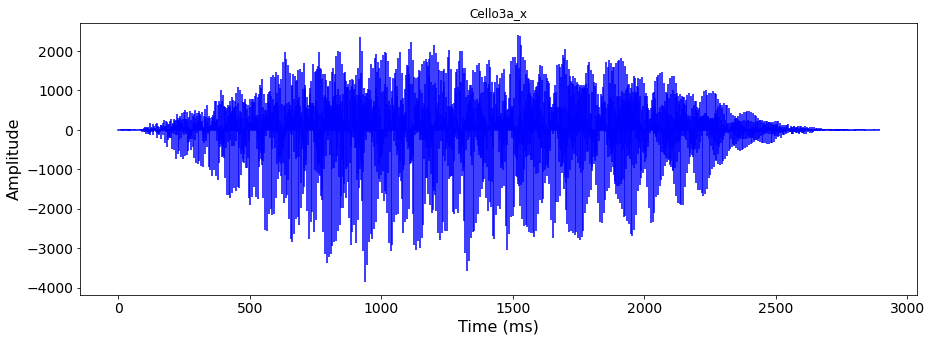

FrHorn1a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 2.3
FrHorn1a : plotting PCM from 0 to 100673
FrHorn1a : plotting PCM from 0.0 ms to 2282.8 ms


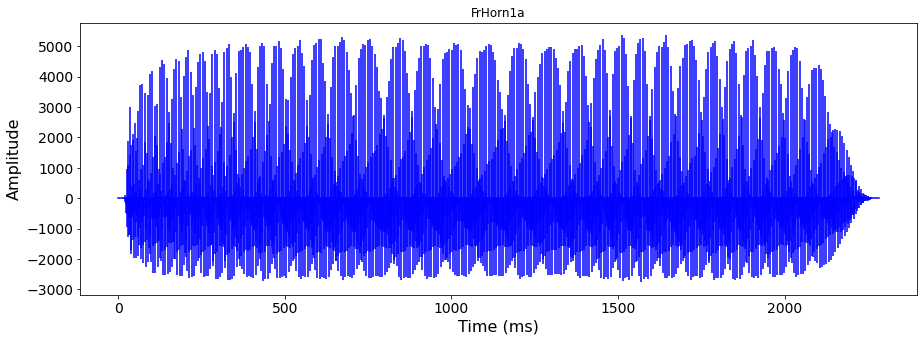

FrHorn2a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 4.2
FrHorn2a : plotting PCM from 0 to 186747
FrHorn2a : plotting PCM from 0.0 ms to 4234.6 ms


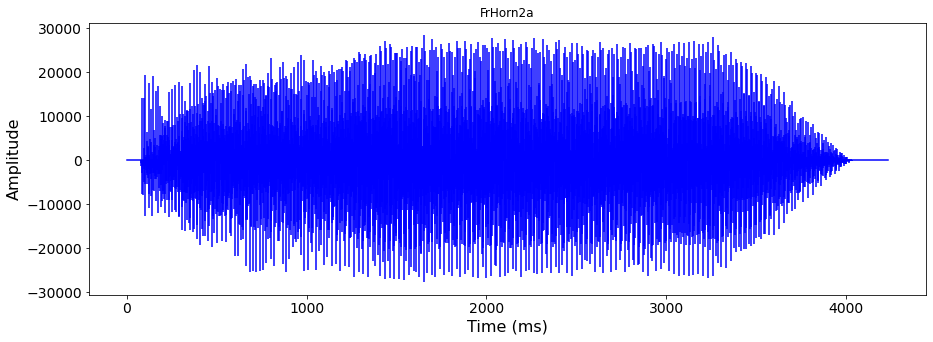

FrHorn3a_x : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 2.6
FrHorn3a_x : plotting PCM from 0 to 115703
FrHorn3a_x : plotting PCM from 0.0 ms to 2623.6 ms


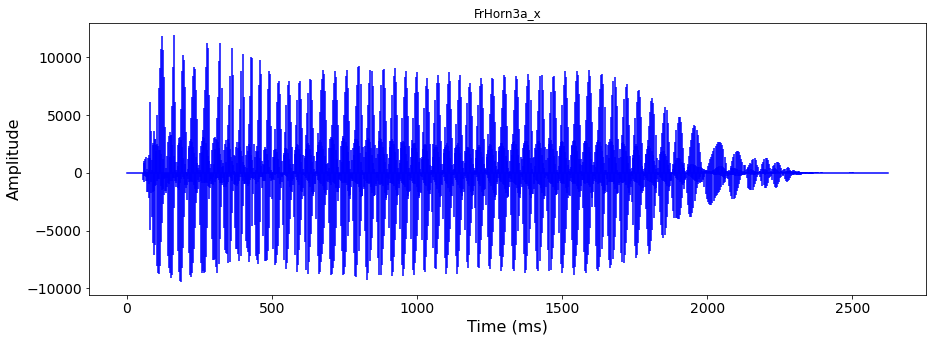

Flute1a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 2.4
Flute1a : plotting PCM from 0 to 105003
Flute1a : plotting PCM from 0.0 ms to 2381.0 ms


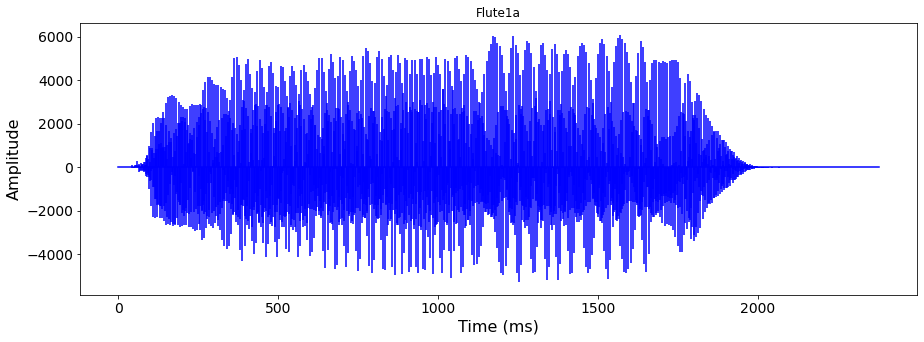

Flute2a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 4.0
Flute2a : plotting PCM from 0 to 175136
Flute2a : plotting PCM from 0.0 ms to 3971.3 ms


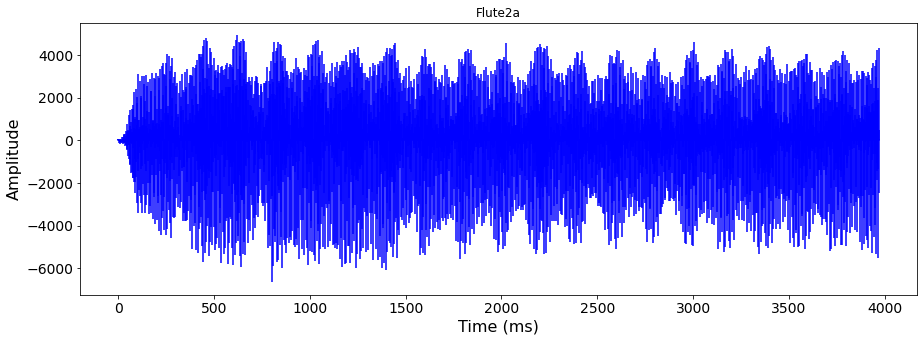

Flute3a_x : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 10.6
Flute3a_x : plotting PCM from 0 to 469028
Flute3a_x : plotting PCM from 0.0 ms to 10635.5 ms


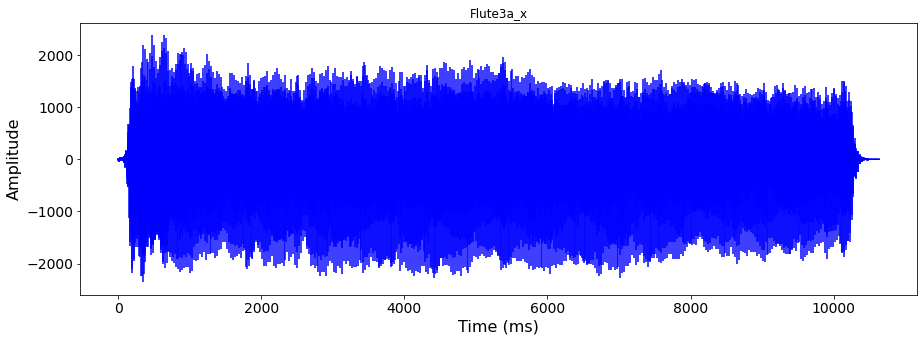

Clarinet1a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 3.3
Clarinet1a : plotting PCM from 0 to 144248
Clarinet1a : plotting PCM from 0.0 ms to 3270.9 ms


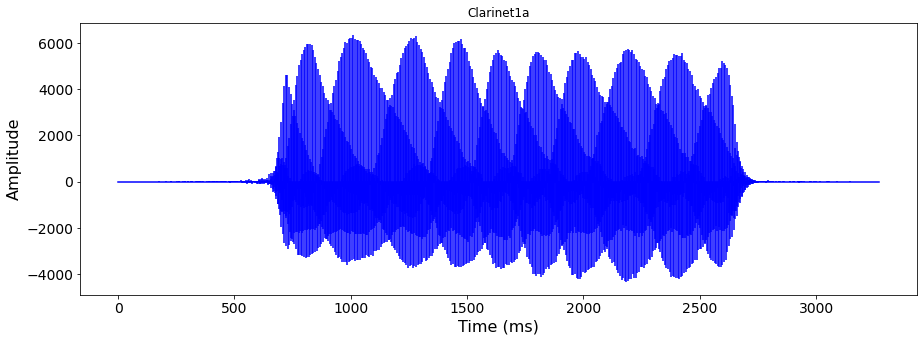

Clarinet2a : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 8.0
Clarinet2a : plotting PCM from 0 to 354865
Clarinet2a : plotting PCM from 0.0 ms to 8046.8 ms


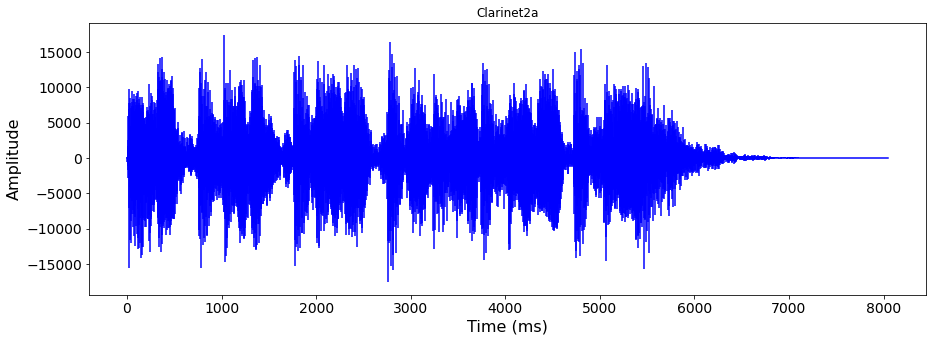

Clarinet3a_x : plotting PCM (plt.stem) subsamplingstep= 43 duration(s)= 4.9
Clarinet3a_x : plotting PCM from 0 to 217049
Clarinet3a_x : plotting PCM from 0.0 ms to 4921.7 ms


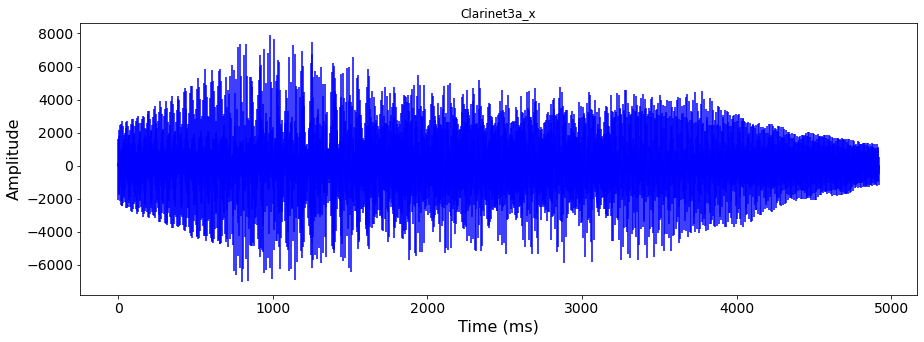

In [26]:
for i in range(len(objects)):
    objects[i].util_plot_pcm_window(subsamplingstep=43)

# printing basic stats and profile of each sample

In [27]:
for i in range(len(objects)):
    print(objects[i])

LABEL=Bassoon1a
len(pcm)=89670 sps=44100 pcm_win=[0,89670] pcm_winsz=89670 isScaled_pcm=False
pcm_dtype=<class 'numpy.int16'> pcm_min=-5216 pcm_max=5778
len(mags/frqs/phas)=0 frq band=0
main_peak=n/a at frq=n/a
peaks=n/a,n/a,..n/a at frqs=n/a,n/a,..n/a - freq0=n/a
pick_strategy= no. peaks=0 maxnext_peak_dist=-1 
LABEL=Bassoon2a
len(pcm)=428309 sps=44100 pcm_win=[0,428309] pcm_winsz=428309 isScaled_pcm=False
pcm_dtype=<class 'numpy.int16'> pcm_min=-4055 pcm_max=4127
len(mags/frqs/phas)=0 frq band=0
main_peak=n/a at frq=n/a
peaks=n/a,n/a,..n/a at frqs=n/a,n/a,..n/a - freq0=n/a
pick_strategy= no. peaks=0 maxnext_peak_dist=-1 
LABEL=Bassoon3a_x
len(pcm)=364450 sps=44100 pcm_win=[0,364450] pcm_winsz=364450 isScaled_pcm=False
pcm_dtype=<class 'numpy.int16'> pcm_min=-21985 pcm_max=24449
len(mags/frqs/phas)=0 frq band=0
main_peak=n/a at frq=n/a
peaks=n/a,n/a,..n/a at frqs=n/a,n/a,..n/a - freq0=n/a
pick_strategy= no. peaks=0 maxnext_peak_dist=-1 
LABEL=Viola1a
len(pcm)=138767 sps=44100 pcm_win=

## comment:
* 11 audio signal samples were acquired.
* all the chosen samples have PCM signals encoded with a int16 datatype.
* some wav files are stereo (two channels) and some are mono (single channel).
* the sampels have different min/max values. min value is usually a negative integer.
* signal normalization will likely be required.

In [28]:
print('thank you.')

thank you.


# END OF data_exp document